# Data Exploration and Preprocessing

## Explore the data

In [1]:
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
%matplotlib inline

df = pd.read_csv("driving_log.csv")

In [2]:
df.describe()

,steering,throttle,brake,speed
count,8036.000000,8036.000000,8036.000000,8036.000000
mean,0.004070,0.869660,0.001970,28.169839
std,0.128840,0.301326,0.036565,6.149327
min,-0.942695,0.000000,0.000000,0.502490
25%,0.000000,0.985533,0.000000,30.183093
50%,0.000000,0.985533,0.000000,30.186400
75%,0.000000,0.985533,0.000000,30.186640
max,1.000000,0.985533,1.000000,30.709360


In [3]:
df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


frames with zero steering 4361
frames with left steering 1775
frames with right steering 1900
total frames: 8036


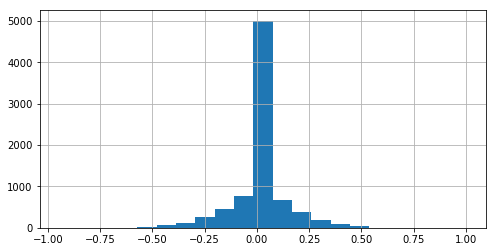

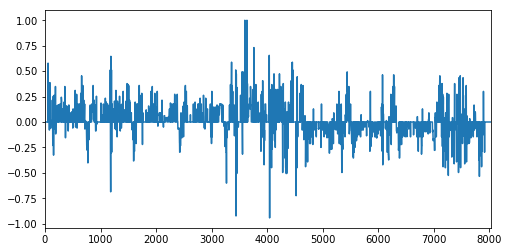

In [4]:
plt.figure(figsize=(8,4))
df.steering.hist(bins=21)

plt.figure(figsize=(8,4))
df.steering.plot()

print("frames with zero steering", df.query('steering == 0')['steering'].count())
print("frames with left steering", df.query('steering < 0')['steering'].count())
print("frames with right steering", df.query('steering > 0')['steering'].count())
print("total frames:", df.steering.count())

## Handle imbalanced data

From the steering distribution graph, we can see that the data is imabalanced and vert biased toward zero or small steering angles. This is expected considering the driving log is obtained from track one in the simulator, which is mostly straight or slight angled.

To balance the data, we will need to undersample the majority class, generate synthetic samples and oversample the minority classes.

In [5]:
# create samples list
#samples = []
#for index, row in df.iterrows():
#    samples.append([row.center.strip(), row.steering])
    
# separate the left, right and center image into its own row
CORRECTION = 0.15
samples = []

for index, row in df.iterrows():
    samples.append([row.center.strip(), float(row.steering)])
    samples.append([row.left.strip(), float(row.steering) + CORRECTION])
    samples.append([row.right.strip(), float(row.steering) - CORRECTION])

## Flip images to balance left turn vs right turn images

From the steering distribution, we can see that the number of left turns vs right turns, and the degrees in these turns are not distributed evenly, otherwise the left side the distribution will closely mirror the right side. 

To balance it out, we will flip all the images that have non-zero steering angles.

In [6]:
def create_flip_samples():
    new_rows = []
    for row in samples:
        steering = float(row[1])
        new_steering = steering * -1
        new_path = row[0].replace(".jpg", "_flip.jpg")
        new_row = [new_path, new_steering]
        new_rows.append(new_row)
        if os.path.exists(new_path) == False:
            image = cv2.imread(row[0])
            new_image = np.fliplr(image)
            cv2.imwrite(new_path, new_image)
    print("created {0} flip samples".format(len(new_rows)))
    return new_rows

samples.extend(create_flip_samples())

created 24108 flip samples


edge start -1.15 end -1.04047619048 count 6
edge start -1.04047619048 end -0.930952380952 count 6
edge start -0.930952380952 end -0.821428571429 count 8
edge start -0.821428571429 end -0.711904761905 count 23
edge start -0.711904761905 end -0.602380952381 count 65
edge start -0.602380952381 end -0.492857142857 count 245
edge start -0.492857142857 end -0.383333333333 count 511
edge start -0.383333333333 end -0.27380952381 count 1701
edge start -0.27380952381 end -0.164285714286 count 2590
edge start -0.164285714286 end -0.0547619047619 count 12635
edge start -0.0547619047619 end 0.0547619047619 count 12636
edge start 0.0547619047619 end 0.164285714286 count 12635
edge start 0.164285714286 end 0.27380952381 count 2590
edge start 0.27380952381 end 0.383333333333 count 1701
edge start 0.383333333333 end 0.492857142857 count 511
edge start 0.492857142857 end 0.602380952381 count 245
edge start 0.602380952381 end 0.711904761905 count 65
edge start 0.711904761905 end 0.821428571429 count 23
e

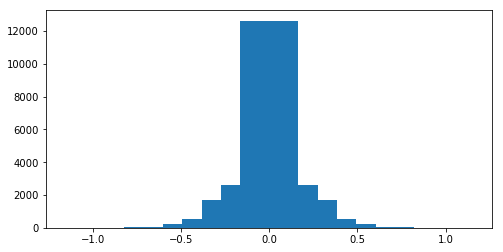

In [7]:
BIN = 21 # number of M, bins
TARGET_BIN_SIZE = 500 #target number of samples in a bin

steerings = np.array(samples)[:,1].astype(float)

# display new steering distribution after left right turn balancing
bin_values, bin_edges = np.histogram(steerings, bins=BIN)
plt.figure(figsize=(8,4))
plt.hist(steerings,bins=BIN)

#print(len(count), len(edges), count, edges)
for i in range(len(bin_values)):
    start = bin_edges[i]
    end = bin_edges[i+1]
    print("edge", "start", start, "end", end, "count", bin_values[i])

print("total frames", len(samples))

In [8]:
balanced_samples = []

def balance_bin(balanced_samples, edge_start, edge_end, target_size):
    bin_samples = []
    for row in samples:
        if row[1] >= edge_start and row[1] <= edge_end:
            bin_samples.append(row)
    bin_count = len(bin_samples)
    if bin_count < target_size:
        balanced_samples.extend(oversample(bin_samples, target_size))
    elif bin_count > target_size:
        balanced_samples.extend(undersample(bin_samples, target_size))

def oversample(bin_samples, target_size):
    ''' oversample by generating more samples from existing samples in the same bin 
    '''
    print("oversample", len(bin_samples), "to", target_size)
    return bin_samples

def undersample(bin_samples, target_size):
    ''' undersample by removing extra samples in the same bin
    '''
    print("undersample", len(bin_samples), "to", target_size)
    random.shuffle(bin_samples)
    return bin_samples[0:target_size]

for i in range(len(bin_values) ):
    print(i, start, " - ", end, "current size", len(balanced_samples))
    start = bin_edges[i]
    end = bin_edges[i+1]
    balance_bin(balanced_samples, start, end, TARGET_BIN_SIZE)
    
print("number of samples", len(balanced_samples))    

0 1.04047619048  -  1.15 current size 0
oversample 6 to 500
1 -1.15  -  -1.04047619048 current size 6
oversample 6 to 500
2 -1.04047619048  -  -0.930952380952 current size 12
oversample 8 to 500
3 -0.930952380952  -  -0.821428571429 current size 20
oversample 23 to 500
4 -0.821428571429  -  -0.711904761905 current size 43
oversample 65 to 500
5 -0.711904761905  -  -0.602380952381 current size 108
oversample 245 to 500
6 -0.602380952381  -  -0.492857142857 current size 353
undersample 511 to 500
7 -0.492857142857  -  -0.383333333333 current size 853
undersample 1701 to 500
8 -0.383333333333  -  -0.27380952381 current size 1353
undersample 2590 to 500
9 -0.27380952381  -  -0.164285714286 current size 1853
undersample 12635 to 500
10 -0.164285714286  -  -0.0547619047619 current size 2353
undersample 12636 to 500
11 -0.0547619047619  -  0.0547619047619 current size 2853
undersample 12635 to 500
12 0.0547619047619  -  0.164285714286 current size 3353
undersample 2590 to 500
13 0.16428571428

5206


(array([   6.,    6.,    8.,   23.,   65.,  245.,  500.,  500.,  500.,
         500.,  500.,  500.,  500.,  500.,  500.,  245.,   65.,   23.,
           8.,    6.,    6.]),
 array([-1.15      , -1.04047619, -0.93095238, -0.82142857, -0.71190476,
        -0.60238095, -0.49285714, -0.38333333, -0.27380952, -0.16428571,
        -0.0547619 ,  0.0547619 ,  0.16428571,  0.27380952,  0.38333333,
         0.49285714,  0.60238095,  0.71190476,  0.82142857,  0.93095238,
         1.04047619,  1.15      ]),
 <a list of 21 Patch objects>)

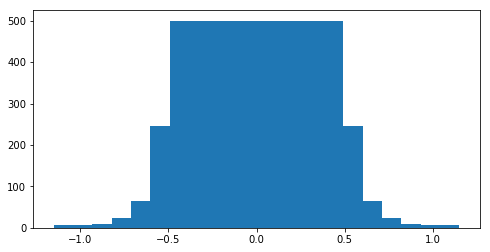

In [9]:
print(len(balanced_samples))
steerings = np.array(balanced_samples)[:,1].astype(float)

# display new steering distribution after left right turn balancing
bin_count, bin_edges = np.histogram(steerings, bins=BIN)
plt.figure(figsize=(8,4))
plt.hist(steerings,bins=BIN)


In [12]:
# save csv
import csv
with open('processed_driving_log.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    for row in balanced_samples:
        writer.writerow(row)
print("done saving csv")

done saving csv


In [ ]:
# explore crop dimension
import matplotlib.image as mpimg
import cv2

list = [1,20,100,1000]

for i in list:
    fig = plt.figure(figsize=(14,7))
    
    img = mpimg.imread("data/" + df['center'].iloc[i])
    ax = fig.add_subplot(2,2,1)
    ax.imshow(img)

    crop1 = img[60:160,0:320]
    ax = fig.add_subplot(2,2,2)   
    ax.imshow(crop1)
    
    crop2 = img[0:140,0:320]
    ax = fig.add_subplot(2,2,3)
    ax.imshow(crop2)

    crop3 = img[70:135,0:320]
    ax = fig.add_subplot(2,2,4)
    ax.imshow(crop3)